In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as un
from scipy.optimize import curve_fit

df_placa = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 1 - Medidores de vazão/dados.xlsx')
df_vent = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 1 - Medidores de vazão/dados.xlsx', sheet_name='venturi')

In [3]:
rho_ar = 1.20
rho_agua = 997
mi = 1.80e-5
g = 9.81

def C_calc(beta, Re, venturi):
    if venturi:
        C = 1.0011 + 0.0123*beta - 0.0169*np.e**(-0.4*Re/1e5)
    else:
        C = 0.5959 + (0.0312*(beta**2.1)) - (0.184*(beta**8)) + ((91.71*(beta**2.5))/(Re**0.75))
    return C

def calc_vazão(Dt, D1, delta_h, venturi=True, beta=None):
    if beta:
        pass
    else: 
        beta = Dt/D1

    At = np.pi*(Dt**2)/4
    A1 = np.pi*(D1**2)/4

    delta_P = rho_agua*g*(delta_h/100)

    lista_m, lista_Re, lista_k = [], [], []
    for j in range(len(delta_P)):
        m_dot  = 10.0
        for i in range(100):

            v = m_dot/(rho_ar*A1)
            Re = (rho_ar*v*D1)/mi

            if venturi:
                C = 1.0011 + 0.0123*beta - 0.0169*np.e**(-0.4*Re/1e5)
            else:
                C = 0.5959 + (0.0312*(beta**2.1)) - (0.184*beta**8) + ((91.71*beta**2.5)/(Re**0.75))

            K = C/np.sqrt(1 - beta**4)
            m_dot_new = K*At*np.sqrt(2*rho_ar*(delta_P[j]))
            
            if abs(m_dot - m_dot_new) < 1e-8:
                break
            else:
                m_dot = m_dot_new

        lista_m.append(m_dot_new)
        lista_Re.append(Re)
        lista_k.append(K)
        
    lista_m = np.array(lista_m)
    lista_Re = np.array(lista_Re)
    lista_k = np.array(lista_k)
    #print(beta)
    lista_Q = lista_m/rho_ar
    lista_V = lista_Q/A1
    return lista_m, lista_Q, lista_V, lista_Re, lista_k, beta #kg/s, m^3/s, m/s

In [4]:
#Placa de orificio
placa = calc_vazão(0.0257, 0.0385, df_placa['del'].values, False)

In [5]:
res_p = pd.DataFrame({'teo':placa[2], 'exp': df_placa['ve'].values, 
                     'erro':abs(df_placa['ve'].values - placa[2])/placa[2]*100})
res_p

,teo,exp,erro
0,5.499215,3.40,38.172991
1,9.944154,5.94,40.266413
2,12.973876,7.65,41.035355
3,14.762445,8.60,41.744068
4,17.331508,9.93,42.705504


In [6]:
#Tubo de venturi
tubo = calc_vazão(0.0244, 0.0385, df_vent['del'].values)

In [7]:
res_t = pd.DataFrame({'teo':tubo[2], 'exp': df_vent['ve'].values, 
                     'erro':abs(df_vent['ve'].values - tubo[2])/tubo[2]*100})
res_t

,teo,exp,erro
0,6.091409,3.60,40.900375
1,11.405657,6.40,43.887493
2,15.850066,8.80,44.479725
3,19.220971,10.58,44.955954
4,25.738509,13.00,49.492024


In [8]:
print(res_t.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
      teo &   exp &      erro \\
\midrule
 6.091409 &  3.60 & 40.900375 \\
11.405657 &  6.40 & 43.887493 \\
15.850066 &  8.80 & 44.479725 \\
19.220971 & 10.58 & 44.955954 \\
25.738509 & 13.00 & 49.492024 \\
\bottomrule
\end{tabular}



In [9]:
#ERROS ENTRE AS PLACAS
res_t = pd.DataFrame({'placa':placa[2], 'tubo': tubo[2], 
                     'erro':abs(tubo[2] - placa[2])/placa[2]*100})
res_t

,placa,tubo,erro
0,5.499215,6.091409,10.768709
1,9.944154,11.405657,14.697104
2,12.973876,15.850066,22.169084
3,14.762445,19.220971,30.201811
4,17.331508,25.738509,48.507041


In [10]:
print(res_t.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
    placa &      tubo &      erro \\
\midrule
 5.499215 &  6.091409 & 10.768709 \\
 9.944154 & 11.405657 & 14.697104 \\
12.973876 & 15.850066 & 22.169084 \\
14.762445 & 19.220971 & 30.201811 \\
17.331508 & 25.738509 & 48.507041 \\
\bottomrule
\end{tabular}



In [11]:
#Modelo
def func(x, a, b, c):
    return a*x**2 + b*x + c

#Fit do modelo
popt_placa, pcov = curve_fit(func, placa[3], placa[4], p0=[1.9, 1, 1])
popt_tubo, pcov = curve_fit(func, tubo[3], tubo[4], p0=[1.9, 1, 1])

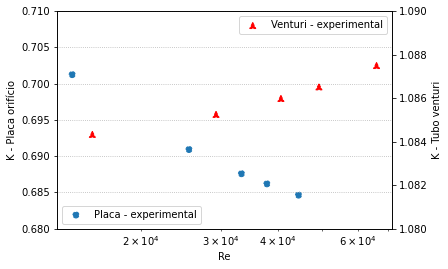

In [12]:
fig, ax = plt.subplots()
ax.set(xlabel=r'Re', ylabel=r'K - Placa orifício', ylim=(0.68, 0.71), xscale='log')

Re = np.linspace(placa[3].min(), placa[3].max())

#ax.plot(Re, func(Re, *[ 1.64740266e-11, -1.49944632e-06, 7.2280440e-01]), ls='--', label='Placa - literatura')
ax.scatter(placa[3], placa[4], marker='o', ls='--', label='Placa - experimental')
ax.legend(loc=3)
ax.grid(ls='dotted')

Re = np.linspace(tubo[3].min(), tubo[3].max())

ax2 = ax.twinx()
ax2.set(xlabel=r'Re', ylabel=r'K - Tubo venturi', ylim=(1.08, 1.09))
#ax2.plot(Re, func(Re, *[-1.25449448e-13,  7.30318185e-08,  1.082e+00]),  c='red', ls='--', label='Venturi - literatura')
ax2.scatter(tubo[3], tubo[4], marker='^', c='red', ls='--', label='Venturi - experimental')
ax2.legend()

fig.savefig('Re_x_k.pdf', bbox_inches='tight')

In [13]:
#Modelo
def func(x, a, b):
    return a*x + b

#Fit do modelo
popt_placa, pcov = curve_fit(func, df_placa['ve'].values*1.2*np.pi*(0.0257**2)/4, placa[1])
popt_tubo, pcov = curve_fit(func, df_vent['ve'].values*1.2*np.pi*(0.0244**2)/4, tubo[1])

D = df_vent['ve'].values*1.2*np.pi*(0.0257**2)/4
new_x = np.linspace(D.min()-0.0002, D.max())

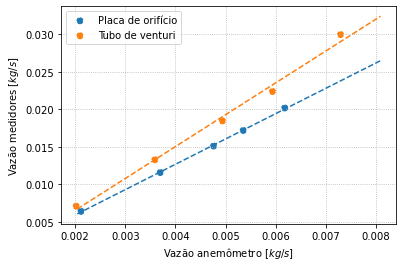

In [14]:
#%matplotlib
fig, ax = plt.subplots()
ax.set(ylabel=r'Vazão medidores $[kg/s]$', xlabel=r'Vazão anemômetro $[kg/s]$')

ax.scatter(df_placa['ve'].values*1.2*np.pi*(0.0257**2)/4, placa[1], marker='o', ls='--', label='Placa de orifício')
ax.plot(new_x, func(new_x,  *popt_placa), ls='--')

ax.scatter(df_vent['ve'].values*1.2*np.pi*(0.0244**2)/4, tubo[1], marker='o', ls='--', label='Tubo de venturi')
ax.plot(new_x, func(new_x,  *popt_tubo), ls='--')

ax.legend()
ax.grid(ls='dotted')

fig.savefig('comparação_vazão.pdf', bbox_inches='tight')